Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


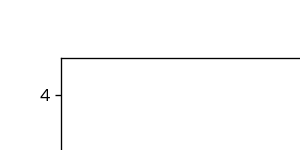

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): 
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
                
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation) 
        else:
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-2,-2))
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(0,2*math.sqrt(3)-2))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,-5.0),np.random.uniform(-5.0,-5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-2.0,2.0),np.random.uniform(-2.0,2*math.sqrt(3)-2),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


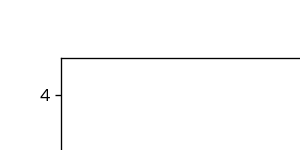

(array([ 1.97301642, -0.06165344, -0.08366882]),
 array([-5.        , -5.        , -2.69479123]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

[4.29411627800323]
[3.62076469071555, 0.9109588113449326]
0 真値: [ 1.65516749 -1.71955996  4.72280725] 推定値: [ 1.73005147 -1.67015266 -1.72149757] 誤差: 0.08971449618728698
1
[0.9829238328201926, 4.28393100098628]
1 真値: [0.18392797 0.91708717 2.84477217] 推定値: [0.24531237 1.00895697 2.96030273] 誤差: 0.1104902928165571
2
[6.725261953199611]
[4.228577839597049, 6.287112570655753]
2 真値: [-0.62109229  1.04193878  5.76223041] 推定値: [-0.76997044  1.05266602 -0.44209795] 誤差: 0.14926411773037151
3
[1.6886874246903485]
[2.33746085300705]
[1.4106072458939938, 3.236227290159432]
[1.2314225503193736, 4.0132965331190515]
[1.0413905883304253, 3.2472124527097463]
[1.2789624096068506, 3.32043510491437]
[1.195285312958894]
3 真値: [-2.12179705 -0.75334844  5.26368281] 推定値: [-2.28966118 -1.10133704 -0.87198379] 誤差: 0.386360495203319
4
[1.7045655282862637]
[0.85242880033136, 4.274000378379746]
[0.8683358821855438, 3.8805760450712556]
[0.8069880959977505, 4.360651495411105]
4 真値: [-0.62666172  0.57910027  3.180866

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[1.546794507621996]
20 真値: [-3.08836553 -0.92485555  5.82473717] 推定値: [-2.90891866 -1.00358475  5.78241033] 誤差: 0.19595781520440186
20
[1.1139440396692017]
[1.3252189138488628, 4.377085219235388]
21 真値: [-0.21429027 -0.47062398  7.5534055 ] 推定値: [ 0.08436402 -0.30777829  1.35415448] 誤差: 0.34016629467379106
21
[1.802372816667106]
22 真値: [ 0.3376676  -2.0295989   2.74443071] 推定値: [ 0.50301884 -2.22111143  8.91824933] 誤差: 0.25301795026528606
22
[2.138555198743402]
[3.4465889972744597]
[1.8466834937087517, 4.321651371520462]
[2.3374336051300175, 4.509300336223169]
[2.546933152102233, 3.816338111564913]
23 真値: [ 0.76465117 -0.82798037  7.47072329] 推定値: [ 0.55842678 -0.89991199  1.08310009] 誤差: 0.2184093845456134
23
[4.004950419922673, 4.255467204836636]
[4.081263044017825, 3.375151637672451]
24 真値: [-2.46705567 -1.29056334  5.40889444] 推定値: [-2.41974796 -0.87535561  5.22317168] 誤差: 0.4178940953843405
24
[3.3588419181373377]
25 真値: [1.41856973 0.33427138 3.81818297] 推定値: [1.03519891 0.532087